In [1]:
import numpy
import pandas as pd
import json
import random
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import confusion_matrix
import pickle as pkl 
import argparse
import gzip
import random
from sklearn import svm
from sklearn import metrics
import seaborn as sns
import scipy as sp
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.
/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tf/lib/python3.6/site-packages/tenso

### 1. Read Data

#### 1.1 Read Raw Json File

In [2]:
data = []
with open('goodreads_reviews_spoiler.json') as f:
    for line in f:
        data.append(json.loads(line))

In [3]:
data[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'timestamp': '2017-08-30',
 'review_sentences': [[0, 'This is a special book.'],
  [0,
   'It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind.'],
  [0,
   'This is what I love about good science fiction - it pushes your thinking about where things can go.'],
  [0,
   "It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I've read."],
  [0,
   'For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc.'],
  [0, 'It is a book about science, and aliens.'],
  [0,
   'The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell.'],
  [1,
   'Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think a

#### 1.2 Segment Spoiler and Non-Spoiler Sentences

In [4]:
spoiler = []
spoiler_ind = []

# For each sentence, decide their percentile rank in the review
non_spoiler = []
non_spoiler_ind = []
for i in data:
    for j in range(len(i['review_sentences'])):
        if i['review_sentences'][j][0] == True:
            spoiler.append(i['review_sentences'][j][1])
            spoiler_ind.append(j/len(i['review_sentences']))
        else:
            non_spoiler.append(i['review_sentences'][j][1])
            non_spoiler_ind.append(j/len(i['review_sentences']))

### 2. EDA

#### 2.1 Basic Statistics

In [5]:
all_review = spoiler + non_spoiler
all_ind = spoiler_ind + non_spoiler_ind

In [6]:
review_df = pd.DataFrame({"review":all_review, "label":[1]*len(spoiler) + [0]*len(non_spoiler), "ind":all_ind})

In [7]:
print("Number of documents is %s"%len(review_df))
print("Number of labels is %s"%len(review_df.label.unique()))
print("Label distribution is as follows: ")
distribution = review_df.groupby('label')['review'].nunique().reset_index()
distribution['proportion'] = distribution['review'] / len(review_df)
print(distribution)
print("Average word length in a review is %s"%(np.mean([len(text.split(' ')) for text in review_df['review']])))

Number of documents is 17672655
Number of labels is 2
Label distribution is as follows: 
   label    review  proportion
0      0  15308234    0.866210
1      1    543823    0.030772
Average word length in a review is 15.0737838768425


In [8]:
review_df.head()

,review,label,ind
0,Though when it got to folding protons into 8 d...,1,0.333333
1,But what would happen if our SETI stations rec...,1,0.380952
2,That part of the book was a bit dark - I would...,1,0.428571
3,I did like how the book unveiled the Trisolara...,1,0.476190
4,It was a smart way to build empathy with them ...,1,0.523810


#### 2.1 Down-sample Non-Spoiler Sentences

In [9]:
random.seed(123)
non_spoiler = random.sample(list(zip(non_spoiler,non_spoiler_ind)), 569724)

In [10]:
non_spoiler_text = [i[0] for i in non_spoiler]
non_spoiler_ind = [i[1] for i in non_spoiler]

In [11]:
all_review = spoiler + non_spoiler_text
all_ind = spoiler_ind + non_spoiler_ind

In [12]:
review_df = pd.DataFrame({"review":all_review, "label":[1]*len(spoiler) + [0]*len(non_spoiler), "ind":all_ind})

In [13]:
review_df.head()

,review,label,ind
0,Though when it got to folding protons into 8 d...,1,0.333333
1,But what would happen if our SETI stations rec...,1,0.380952
2,That part of the book was a bit dark - I would...,1,0.428571
3,I did like how the book unveiled the Trisolara...,1,0.476190
4,It was a smart way to build empathy with them ...,1,0.523810


#### 2.2 Density Plot of Proportion of Spoiler Sentence in Entire Review

In [44]:
prop  = []
for i in data:
    tot = len(i['review_sentences'])
    tmp = 0
    for j in i['review_sentences']:
        if j[0] == True:
            tmp += 1
    prop.append(tmp/tot)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:1659: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Proportion of Spoiler')]

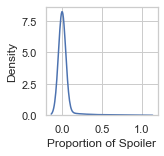

In [58]:
sns.set(rc={'figure.figsize':(2, 2)})
sns.set_style('whitegrid')
ax = sns.kdeplot(np.array(prop), bw=0.5)
ax.set(xlabel='Proportion of Spoiler')

#### 2.3 Density Plots of Percentile Rank of Spoiler vs. Non-Spoiler Sentences in Review Text

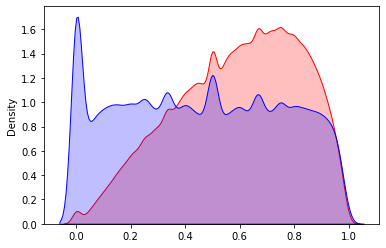

In [68]:
p1=sns.kdeplot(spoiler_ind, shade=True, color="r")
p1=sns.kdeplot(non_spoiler_ind, shade=True, color="b")

#### 2.4 Bar plots of word length for spoiler and non-spoiler sentences

In [8]:
num_word_sp = []
num_word_nsp = []

for i in spoiler:
    num_word_sp.append(len(i.split()))
for i in non_spoiler:
    num_word_nsp.append(len(i.split()))

In [9]:
np.mean(num_word_sp)

16.330421397027333

In [10]:
np.mean(num_word_nsp)

15.026560359741847

In [24]:
dat = pd.DataFrame({'Type':['Spoiler', 'Non-Spoiler'], 'Word Length':[16.33, 15.02]})

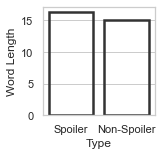

In [25]:
sns.set(rc={'figure.figsize':(2, 2),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
# sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":5})  
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Type", y="Word Length", data=dat, linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")

#### 2.5 Bar plot of occurrences of common words related to plots

In [7]:
spoiler_die = 0
non_spoiler_die = 0
for i in spoiler:
    if 'die' in i:
        spoiler_die += 1
for i in non_spoiler:
    if 'die' in i:
        non_spoiler_die += 1

In [10]:
occurance_die = pd.DataFrame({'Type':['Spoiler', 'Non-Spoiler'], 'Occurances':[spoiler_die/len(spoiler), non_spoiler_die/len(non_spoiler)]})

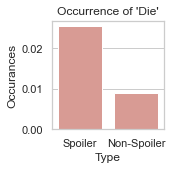

In [17]:
sns.set(rc={'figure.figsize':(2, 2),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Type", y="Occurances", data=occurance_die, color="salmon", saturation=.5).set_title('Occurrence of \'Die\'')

In [18]:
spoiler_survive = 0
non_spoiler_survive = 0
for i in spoiler:
    if 'survive' in i:
        spoiler_survive += 1
for i in non_spoiler:
    if 'survive' in i:
        non_spoiler_survive += 1

In [19]:
occurance_survive = pd.DataFrame({'Type':['Spoiler', 'Non-Spoiler'], 'Occurances':[spoiler_survive/len(spoiler), non_spoiler_survive/len(non_spoiler)]})

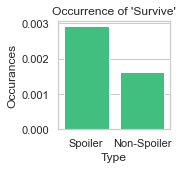

In [23]:
sns.set(rc={'figure.figsize':(2, 2),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="white")
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Type", y="Occurances", data=occurance_survive, color="springgreen", saturation=.5).set_title('Occurrence of \'Survive\'')

### 3. Process Review Text

#### 3.1 Remove Stop Words and Tokenization

In [14]:
stop_words = set(stopwords.words('english')) 

def process_review(text):
    clean_rev = [w.lower() for w in word_tokenize(text) if w not in stop_words and w.isalpha()]
    return ' '.join(clean_rev)

In [15]:
review_sentence = list(review_df.review)

In [16]:
clean_review = list(map(process_review, review_sentence))

In [17]:
review_df['clean_review'] = clean_review
review_df = review_df.drop(columns=['review'])

In [18]:
review_df.head()

,label,ind,clean_review
0,1,0.333333,though got folding protons dimensions i think ...
1,1,0.380952,but would happen seti stations received messag...
2,1,0.428571,that part book bit dark i would like think hum...
3,1,0.476190,i like book unveiled trisolaran culture game
4,1,0.523810,it smart way build empathy also understand gon...


#### 3.2 Train/Test Split

In [19]:
# train, test = train_test_split(review_df[['clean_review', 'label']].dropna(), random_state = 123)
train, test = train_test_split(review_df.dropna(), random_state = 123)

train_x = train['clean_review'].values
train_x_other = train['ind'].values
train_y = train['label'].values
test_x = test['clean_review'].values
test_x_other = test['ind'].values
test_y = test['label'].values

In [20]:
def tf_idf(train, test, max_df=0.95, ngram=(1,1)):

    tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=max_df, ngram_range=ngram)
    tfidf_vectorizer.fit_transform(train)
    train_feature = tfidf_vectorizer.transform(train)
    test_feature = tfidf_vectorizer.transform(test)
    return train_feature, test_feature

### 4. Modeling
#### 4.1 SVM

In [18]:
train_x_tfidf, test_x_tfidf = tf_idf(train_x, test_x, max_df=0.95, ngram=(1,1))

In [19]:
clf = svm.LinearSVC(random_state=123, penalty='l2', C=1.0, loss = 'hinge')
clf.fit(train_x_tfidf, train_y)
pred = clf.predict(test_x_tfidf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [27]:
def performance_metric(test, pred):
    precision = metrics.precision_score(test, pred)
    recall = metrics.recall_score(test, pred)
    f1 = metrics.f1_score(test, pred)
    accuracy = metrics.accuracy_score(test, pred)
    roc_auc_score = metrics.roc_auc_score(test, pred)
    return accuracy, precision, recall, f1, roc_auc_score

In [21]:
performance_metric(test_y, pred)

(0.6935779430039809,
 0.6818100577889281,
 0.7242281270435034,
 0.7023792475604018,
 0.6936234961612784)

In [22]:
train_x_tfidf, test_x_tfidf = tf_idf(train_x, test_x, max_df=0.95, ngram=(1,2))

In [23]:
clf = svm.LinearSVC(random_state=123, penalty='l2', C=1.0, loss = 'hinge')
clf.fit(train_x_tfidf, train_y)
pred = clf.predict(test_x_tfidf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [24]:
performance_metric(test_y, pred)

(0.6998090303374968,
 0.68902,
 0.7267172459376032,
 0.7073667352225557,
 0.6998490220770649)

In [25]:
train_x_tfidf, test_x_tfidf = tf_idf(train_x, test_x, max_df=0.95, ngram=(1,1))

In [26]:
clf = svm.LinearSVC(random_state=123, penalty='l2', C=15.0, loss = 'hinge')
clf.fit(train_x_tfidf, train_y)
pred = clf.predict(test_x_tfidf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [27]:
performance_metric(test_y, pred)

(0.6881016070939613,
 0.6810450687598798,
 0.7058409917099684,
 0.6932213689851389,
 0.688127971861518)

In [28]:
train_x_tfidf, test_x_tfidf = tf_idf(train_x, test_x, max_df=0.95, ngram=(1,2))

In [29]:
clf = svm.LinearSVC(random_state=123, penalty='l2', C=15.0, loss = 'hinge')
clf.fit(train_x_tfidf, train_y)
pred = clf.predict(test_x_tfidf)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [30]:
performance_metric(test_y, pred)

(0.661481699910834,
 0.657174241384045,
 0.6730746243469579,
 0.6650294047151755,
 0.6614989296380583)

#### 4.2 Logistic Regression

In [15]:
train_x_tfidf_12, test_x_tfidf_12 = tf_idf(train_x, test_x, max_df=0.95, ngram=(1,2))

In [16]:
lr_12gram_c5 = LogisticRegression(solver='liblinear', random_state=123, C=5, penalty='l1', max_iter=100)
model = lr_12gram_c5.fit(train_x_tfidf_12,train_y)
pred = model.predict(test_x_tfidf_12)
performance_metric(test_y, pred)

(0.6887756176675022,
 0.6816692556590399,
 0.7065933525056427,
 0.6939075673772087,
 0.6888020988813415)

In [17]:
lr_12gram_c15 = LogisticRegression(solver='liblinear', random_state=123, C=5, penalty='l2', max_iter=100)
model = lr_12gram_c15.fit(train_x_tfidf_12,train_y)
pred = model.predict(test_x_tfidf_12)
performance_metric(test_y, pred)

(0.6997809465635992,
 0.6906532879605095,
 0.7220976100239771,
 0.706025512782172,
 0.6998141142104771)

In [18]:
lr_12gram_c15_l1 = LogisticRegression(solver='liblinear', random_state=123, C=15, penalty='l1', max_iter=100)
model = lr_12gram_c15_l1.fit(train_x_tfidf_12,train_y)
pred = model.predict(test_x_tfidf_12)
performance_metric(test_y, pred)

(0.6750847778924531,
 0.6694231228465186,
 0.6898796925867852,
 0.6794974790847138,
 0.6751067665067925)

In [19]:
lr_12gram_c15_l2 = LogisticRegression(solver='liblinear', random_state=123, C=15, penalty='l2', max_iter=100)
model = lr_12gram_c15_l2.fit(train_x_tfidf_12,train_y)
pred = model.predict(test_x_tfidf_12)
performance_metric(test_y, pred)

(0.6908292436337595,
 0.6833362677248533,
 0.7095465444138969,
 0.6961948029100392,
 0.6908570618075597)

#### 4.3 Additional Features of Percentile Rank of Sentence

#### 4.3.1 SVM

In [22]:
def tf_idf(train, test, max_df=0.95, ngram=(1,1)):

    tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_df=max_df, ngram_range=ngram)
    tfidf_vectorizer.fit_transform(train)
    train_feature = tfidf_vectorizer.transform(train)
    test_feature = tfidf_vectorizer.transform(test)
    return tfidf_vectorizer, train_feature, test_feature

In [23]:
vectorizer, train_x_tfidf, test_x_tfidf = tf_idf(train_x, test_x, max_df=0.95, ngram=(1,2))

In [24]:
final = sp.sparse.hstack((train_x_tfidf, np.reshape(train_x_other, (-1, 1))))

In [25]:
clf = svm.LinearSVC(random_state=123, penalty='l2', C=1.0, loss = 'hinge')
clf.fit(final, train_y)
test_final = sp.sparse.hstack((test_x_tfidf, np.reshape(test_x_other, (-1, 1))))
pred = clf.predict(test_final)

/opt/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [28]:
performance_metric(test_y, pred)

(0.7157571034395602,
 0.7022099848793983,
 0.7477833482164831,
 0.7242804799978206,
 0.7158047017366567)

#### 4.3.1.1 Save model artifacts

In [29]:
with open('vectorizer.pkl', 'wb') as f:
    pkl.dump(vectorizer, f)

In [30]:
pkl.dump(clf, open('svm.sav', 'wb'))

#### 4.3.2 LR

In [24]:
lr_12gram_c15 = LogisticRegression(solver='liblinear', random_state=123, C=5, penalty='l2', max_iter=100)
model = lr_12gram_c15.fit(final,train_y)

In [26]:
pred = model.predict(test_final)
performance_metric(test_y, pred)

(0.7148268284292043,
 0.7042166738105443,
 0.7393386256407372,
 0.7213503881233899,
 0.7148632585450098)

#### 4.4 CNN

##### The following codes are adapted from lecture5.py published on Canvas

In [82]:
"""

An implementation of text classifier using word-level embeddings
and a convolutional neural network.

Disclaimer: tested on Keras==2.2.4 with tensorflow, you might have to modify the code to work with later keras versions or cntk, theano backends

"""

import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.DEBUG)

from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout
from keras.layers.pooling import MaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import gensim
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import keras


def token_to_index(token, dictionary):
    """
    Given a token and a gensim dictionary, return the token index
    if in the dictionary, None otherwise.
    Reserve index 0 for padding.
    """
    if token not in dictionary.token2id:
        return None
    return dictionary.token2id[token] + 1

def texts_to_indices(text, dictionary):
    """
    Given a list of tokens (text) and a gensim dictionary, return a list
    of token ids.
    """
    result = list(map(lambda x: token_to_index(x, dictionary), text))
    return list(filter(None, result))

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def auc_m(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def train(train_texts, train_labels, dictionary, model_file=None, EMBEDDINGS_MODEL_FILE=None):
    """
    Train a word-level CNN text classifier.
    :param train_texts: tokenized and normalized texts, a list of token lists, [['sentence', 'blah', 'blah'], ['sentence', '2'], .....]
    :param train_labels: the label for each train text
    :param dictionary: A gensim dictionary object for the training text tokens
    :param model_file: An optional output location for the ML model file
    :param EMBEDDINGS_MODEL_FILE: An optinal location for pre-trained word embeddings file location
    :return: the produced keras model, the validation accuracy, and the size of the training examples
    """
    assert len(train_texts)==len(train_labels)
    # compute the max sequence length
    # why do we need to do that?
    lengths=list(map(lambda x: len(x), train_texts))
    a = np.array(lengths)
    MAX_SEQUENCE_LENGTH = int(np.percentile(a, SEQUENCE_LENGTH_PERCENTILE))
    # convert all texts to dictionary indices
    #train_texts_indices = list(map(lambda x: texts_to_indices(x[0], dictionary), train_texts))
    train_texts_indices = list(map(lambda x: texts_to_indices(x, dictionary), train_texts))
    # pad or truncate the texts
    x_data = pad_sequences(train_texts_indices, maxlen=int(MAX_SEQUENCE_LENGTH))
    # convert the train labels to one-hot encoded vectors
    train_labels = keras.utils.to_categorical(train_labels)
    y_data = train_labels

    model = Sequential()

    # create embeddings matrix from word2vec pre-trained embeddings, if provided
    if pretrained_embedding:
        embeddings_index = gensim.models.KeyedVectors.load_word2vec_format(EMBEDDINGS_MODEL_FILE, binary=True)
        embedding_matrix = np.zeros((len(dictionary) + 1, EMBEDDING_DIM))
        for word, i in dictionary.token2id.items():
            embedding_vector = embeddings_index[word] if word in embeddings_index else None
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector
        model.add(Embedding(len(dictionary) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=TRAINABLE_EMBEDDINGS))
    else:
        model.add(Embedding(len(dictionary) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH))
    # add drop out for the input layer, why do you think this might help?
    model.add(Dropout(dropout_rate))
    # add a 1 dimensional conv layer
    # a rectified linear activation unit, returns input if input > 0 else 0
    model.add(Conv1D(filters=n_filters,
                     kernel_size=window_size,
                     activation='relu'))
    # add a max pooling layer
    model.add(MaxPooling1D(MAX_SEQUENCE_LENGTH - window_size + 1))
    model.add(Flatten())

    # add 0 or more fully connected layers with drop out
    for _ in range(n_layers):
        model.add(Dropout(dropout_rate))
        model.add(Dense(hidden_units,
                        activation=dense_activation,
                        kernel_regularizer=l2(l2_penalty),
                        bias_regularizer=l2(l2_penalty),
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros'))

    # add the last fully connected layer with softmax activation
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(train_labels[0]),
                    activation='softmax',
                    kernel_regularizer=l2(l2_penalty),
                    bias_regularizer=l2(l2_penalty),
                    kernel_initializer='glorot_uniform',
                    bias_initializer='zeros'))

    # compile the model, provide an optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy', f1_m, auc_m])

    # print a summary
    print(model.summary())


    # train the model with early stopping
    early_stopping = EarlyStopping(patience=patience)
    Y = np.array(y_data)

    fit = model.fit(x_data,
                    Y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=VALIDATION_SPLIT,
                    verbose=1,
                    callbacks=[early_stopping])

    print(fit.history.keys())
    val_accuracy = fit.history['acc'][-1]
    print(val_accuracy)
    # save the model

    # if model_file:
    #     model.save(model_file)
    return model, fit.history['val_f1_m'][-1], fit.history['val_auc_m'][-1]


# which lines of code define model regularizers, which lines define model optimizers?

def tokenize(text):
    # for each token in the text (the result of text.split(),
    # apply a function that strips punctuation and converts to lower case.
    tokens = map(lambda x: x.strip(',.&').lower(), text.split())
    # get rid of empty tokens
    tokens = list(filter(None, tokens))
    return tokens

In [22]:
subset = train.sample(150000)

In [23]:
texts = map(lambda x:x.split(), subset['clean_review'])

In [24]:
texts = list(texts)

In [25]:
labels = list(subset['label'])

In [26]:
mydict = gensim.corpora.Dictionary(texts)

2020-11-23 11:18:19,742 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-11-23 11:18:19,900 : INFO : adding document #10000 to Dictionary(12836 unique tokens: ['lots', 'love', 'series', 'get', 'away']...)
2020-11-23 11:18:20,039 : INFO : adding document #20000 to Dictionary(18077 unique tokens: ['lots', 'love', 'series', 'get', 'away']...)
2020-11-23 11:18:20,184 : INFO : adding document #30000 to Dictionary(22136 unique tokens: ['lots', 'love', 'series', 'get', 'away']...)
2020-11-23 11:18:20,324 : INFO : adding document #40000 to Dictionary(25430 unique tokens: ['lots', 'love', 'series', 'get', 'away']...)
2020-11-23 11:18:20,466 : INFO : adding document #50000 to Dictionary(28241 unique tokens: ['lots', 'love', 'series', 'get', 'away']...)
2020-11-23 11:18:20,611 : INFO : adding document #60000 to Dictionary(30821 unique tokens: ['lots', 'love', 'series', 'get', 'away']...)
2020-11-23 11:18:20,757 : INFO : adding document #70000 to Dictionary(33073 unique tokens: 

In [93]:
EMBEDDING_DIM = 100
SEQUENCE_LENGTH_PERCENTILE = 90
n_layers = 2
hidden_units = 500
batch_size = 150
pretrained_embedding = False
# if we have pre-trained embeddings, specify if they are static or non-static embeddings
TRAINABLE_EMBEDDINGS = True
patience = 10
dropout_rate = 0.3
n_filters = 100
window_size = 8
dense_activation = "relu"
l2_penalty = 0.0001
epochs = 10
VALIDATION_SPLIT = 0.1

In [94]:
model, f1, auc = train(texts, labels, mydict, model_file='yelp_cnn.model')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 16, 100)           4598400   
_________________________________________________________________
dropout_53 (Dropout)         (None, 16, 100)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 9, 100)            80100     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 1, 100)            0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 100)               0         
_________________________________________________________________
dropout_54 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 500)               50500     
__________

In [95]:
f1

0.6504666084051132

In [96]:
auc

0.8305102503299713

In [89]:
EMBEDDING_DIM = 100
SEQUENCE_LENGTH_PERCENTILE = 90
n_layers = 2
hidden_units = 500
batch_size = 150
pretrained_embedding = False
# if we have pre-trained embeddings, specify if they are static or non-static embeddings
TRAINABLE_EMBEDDINGS = True
patience = 10
dropout_rate = 0.3
n_filters = 100
window_size = 8
dense_activation = "sigmoid"
l2_penalty = 0.0001
epochs = 10
VALIDATION_SPLIT = 0.1

In [90]:
model, f1, auc = train(texts, labels, mydict, model_file='yelp_cnn.model')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 16, 100)           4598400   
_________________________________________________________________
dropout_49 (Dropout)         (None, 16, 100)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 9, 100)            80100     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 1, 100)            0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 100)               0         
_________________________________________________________________
dropout_50 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 500)               50500     
__________

In [91]:
f1

0.6431332737207412

In [92]:
auc

0.7849175953865051